### Telecom: Identifying Ineffective Operators

A virtual telephony service is developing a new function that will give supervisors information on the least effective operators. An operator is considered ineffective if they have a large number of missed incoming calls (internal and external) and a long waiting time for incoming calls. Moreover, if an operator is supposed to make outgoing calls, a small number of them is also a sign of ineffectiveness.

#### Goal

Identify ineffective operators based on:

* A large number of missed incoming calls (internal and external).
* A long waiting time for incoming calls.
* A small number of outgoing calls.

#### Table of contents:

* [Open the data files and read the general information](#chapter1)
   
* [Prepare the data for analysis](#chapter2)

    * Check for missing values
    * Replace\delete missing values
    * Check for duplicate values
    * Remove duplicates
    * Check type correspondence
    * Convert types if needed

* [EDA](#chapter3)

    * Study distribution of data
    * Find outliers 

* [Identifying ineffective operators](#chapter4)

    * Determine the threshold after which the number of missed calls will be considered too high
    * Determine the threshold after which the waiting time will be considered too long
    * Determine the threshold after which the number of outgoing calls will be considered too small

* [Test hypothesis](#chapter5)
    
    * If there is statistically significant difference in average waiting time between effective and ineffective operators

* [Conclusions](#chapter6)


Link to presentation: https://docs.google.com/presentation/d/1NYwhVUyjQnjgwyRLGPr3tmdhDxrAaYl5qbqKdSwlGQM/edit?usp=sharing

Link to Tableau dashbord: https://public.tableau.com/profile/nataliy.smushkin#!/vizhome/CallMeMaybe_16178217776690/Dashboard1

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import datetime 
import matplotlib.dates
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/telecom_dataset_us.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [3]:
df.isnull().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [4]:
df.duplicated().sum()

4900

Our dataset has 53902 entries, 9 columns.

* user_id — client account ID
* date — date the statistics were retrieved
* direction — call direction (out for outgoing, in for incoming)
* internal — whether the call was internal (between a client's operators)
* operator_id — operator identifier
* is_missed_call — whether the call was missed
* calls_count — number of calls
* call_duration — call duration (excluding waiting time)
* total_call_duration — call duration (including waiting time)

There are 117 missing values in "internal" column and 8172 missing values in "operator_id" column. Also, there are 4900 duplicated rows in our dataset.

In [5]:
clients = pd.read_csv('/datasets/telecom_clients_us.csv')
clients.info() 
clients.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [6]:
clients.isnull().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

In [7]:
clients.duplicated().sum()

0

Clients dataset has 732 entries, 3 columns.

* user_id
* tariff_plan — client's current plan
* date_start — client's registration date

No missing values, no duplicates.

### Data preprossesing<a class="anchor" id="chapter2"></a>

Let's begin with smaller dataset "clients". We'll convert registration date "date_start" into date type.

In [8]:
clients['date_start'] = pd.to_datetime(clients['date_start'], format="%Y-%m-%d")

For the second dataset, we'll also convert "date" column into date type.

In [9]:
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")

Regarding missing values in "operator_id" and "internal" columns, there is no way to determine operator_id (since we don't know the algorithm that assigns users to operators) and couldn't know wether the call was internal (between the client's operators) or not. Hence, we must delete all these rows.

In [10]:
df.dropna(subset=['internal', 'operator_id'], inplace=True)

Now we'll drop duplicates

In [11]:
df.drop_duplicates(inplace=True)

Convert "operator_id" column into integer type.

In [12]:
df['operator_id'] = df['operator_id'].astype(int)

Let's add two columns: "waiting_time" column that will show how long the customer has had to wait until the operator answers his call and "avg_waiting_time_per_call"

In [13]:
df['waiting_time'] = df['total_call_duration'] - df['call_duration']
df['avg_waiting_time_per_call'] = df['waiting_time'] / df['calls_count']

So, we have two datasets:

* clients - 732 entries, 3 columns. No missing values, no duplicates. "date_start" column type was converted to date type

* df - 53902 entries, 9 columns. "date" column type was converted into date type, "operator_id" - into integer type. There were 117 missing values in "internal" column and 8172 missing values in "operator_id" column. Also, there were 4900 duplicated rows in our dataset. We had to delete all missing and duplicated rows. As a result we lost 23% of the data.

We have added to df dataset "waiting_time" column showing how long the customer had to wait until the operator answers his call. 

### Exploratory Data Analysis<a class="anchor" id="chapter3"></a>

Let's begin with the smaller dataset - clients

In [14]:
clients['tariff_plan'].unique()

array(['A', 'C', 'B'], dtype=object)

There are three unique tariffs: A, B, C.

In [15]:
clients['user_id'].nunique()

732

We have 732 users in clients dataset.

In [16]:
tariff = clients.groupby('tariff_plan')['user_id'].count().reset_index()
tariff = tariff.sort_values(by ='user_id', ascending = False)

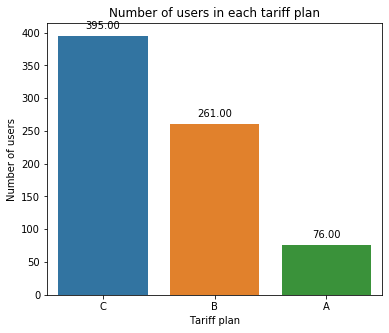

In [17]:
plt.figure(figsize=(6, 5))
ax = sns.barplot(data = tariff, x='tariff_plan', y='user_id')

plt.title('Number of users in each tariff plan')
plt.xlabel('Tariff plan')
plt.ylabel('Number of users')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                xy=(p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()

We can see that the tariff plan C is the most popular, A - is the least popular.

In [18]:
clients['date_start'].min(), clients['date_start'].max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2019-10-31 00:00:00'))

We have data on registrations from 01-08-2019 till 31-10-2019.

Let's look at distribution of registrations per day. 

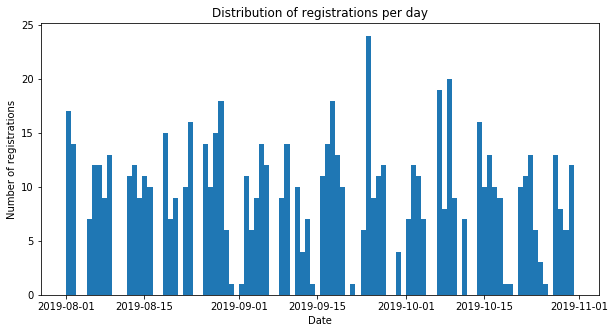

In [19]:
fig = plt.figure(figsize=(10,5))

plt.hist(clients['date_start'], bins=100)

plt.title('Distribution of registrations per day')
plt.xlabel('Date')
plt.ylabel('Number of registrations')
plt.show()

We can not see any pattern in the distribution of number of registrations over 3 months.

Now let's analyze df dataset.

In [20]:
df['user_id'].nunique()

290

In [21]:
df['operator_id'].nunique()

1092

We can see that only 290 of all registered users (732 users) started using their tariff plan.

We have 1092 operators. 

In [22]:
df.groupby('user_id')['operator_id'].nunique().describe()

count    290.000000
mean       3.765517
std        5.717712
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       50.000000
Name: operator_id, dtype: float64

We can see that users can have from 1 to 50 operators.

In [23]:
df['date'].describe()

count                         41491
unique                          118
top       2019-11-25 00:00:00+03:00
freq                            987
first     2019-08-02 00:00:00+03:00
last      2019-11-28 00:00:00+03:00
Name: date, dtype: object

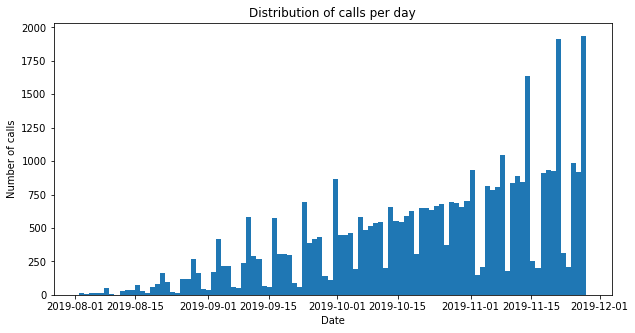

In [24]:
fig = plt.figure(figsize=(10,5))

plt.hist(df['date'], bins=100)

plt.title('Distribution of calls per day')
plt.xlabel('Date')
plt.ylabel('Number of calls')
plt.show()

We have distribution of calls from 02-08-2019 till 28-11-2019. We can see that the number of calls increasing during this period. We also can see peaks in some days and than downs. Probably, downs were caused by low activity at weekends.

Let's look at direction column (out - for outgoing calls, in - incoming calls)

In [25]:
df['direction'].value_counts()

out    28813
in     12678
Name: direction, dtype: int64

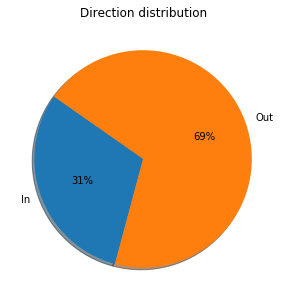

In [26]:
plt.figure(figsize=(10, 5))

direction = df.groupby('direction')['operator_id'].count().reset_index()
direction.columns = ['direction', 'count']

labels = ['In', 'Out']
plt.pie(direction['count'], labels=labels, autopct='%0.f%%', shadow=True, startangle=145)
plt.title('Direction distribution')
plt.show()

About 70% of calls are outgoing.

Let's look at internal column (wether the call was internal - between client's operators)

In [27]:
df['internal'].value_counts()

False    36161
True      5330
Name: internal, dtype: int64

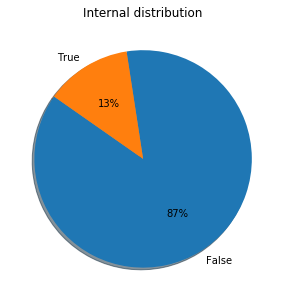

In [28]:
plt.figure(figsize=(10, 5))

internal = df.groupby('internal')['operator_id'].count().reset_index()
internal.columns = ['internal', 'count']

labels = ['False', 'True']
plt.pie(internal['count'], labels=labels, autopct='%0.f%%', shadow=True, startangle=145)
plt.title('Internal distribution')
plt.show()

About 13% of calls made between the operators.

Let's check if there are some logical mistakes. Such as call duration more than total call duration.

In [29]:
df.query('(call_duration > total_call_duration)')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,avg_waiting_time_per_call


All is fine here.

Let's check if the call is missed but call duration is more than 0 seconds.

In [30]:
df.query('(is_missed_call == True and call_duration >0)').shape[0]

295

Let's look how many of such calls last more than 2 seconds 

In [31]:
df.query('(is_missed_call == True and call_duration > 2)').shape[0]

184

Those missed calls with duration 1-2 seconds are technical errors, when the connection with other part was not established, but duration lasts for like 1-2 seconds. We will leave them as they are. But we'll drop those that last more than 2 seconds.  

In [32]:
df = df.query('~(is_missed_call == True and call_duration > 2)')

Also let's check the situation when missed call is False and duration is 0.

In [33]:
df.query('(is_missed_call == False and call_duration == 0)').shape[0]

17

Drop  them.

In [34]:
df = df.query('~(is_missed_call == False and call_duration == 0)')

Let's check what we have now.

In [35]:
df['is_missed_call'].value_counts()

False    27365
True     13925
Name: is_missed_call, dtype: int64

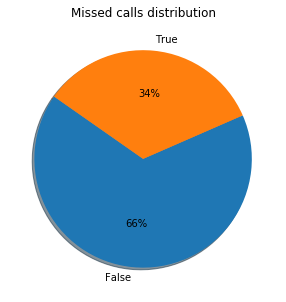

In [36]:
plt.figure(figsize=(10, 5))

is_missed = df.groupby('is_missed_call')['operator_id'].count().reset_index()
is_missed.columns = ['is_missed_call', 'count']

labels = ['False', 'True']
plt.pie(is_missed['count'], labels=labels, autopct='%0.f%%', shadow=True, startangle=145)
plt.title('Missed calls distribution')
plt.show()

About 34% calls were missed.

Now let's look at "calls_count" column.

In [37]:
 df['calls_count'].describe()

count    41290.000000
mean        16.995350
std         59.922036
min          1.000000
25%          2.000000
50%          4.000000
75%         14.000000
max       4817.000000
Name: calls_count, dtype: float64

Max value is 4817 calls - impossible number of calls per day.  The median is 4 calls, mean is 17 calls. We have a right skewed distribution. Let's look at histogram. 

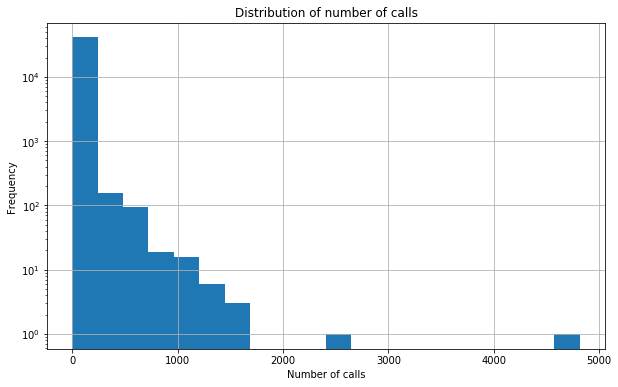

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))
df['calls_count'].hist(log=True, bins=20)
plt.title('Distribution of number of calls')
plt.xlabel('Number of calls')
plt.ylabel('Frequency')
plt.show()

In [39]:
np.percentile(df['calls_count'], [90, 95, 99])

array([ 38.,  65., 166.])

We have outliers here. 65 calls per day (let's take 9 hour working day) means make a call each 8 minutes (probably it is possible if our client is telemarketing company). More than that sounds too much calls per day. We'll delete data with more than 65 calls.

In [40]:
df = df.query('calls_count < 65')

Let's check outliers for call_duration.

In [41]:
df['call_duration'].describe()

count    39176.000000
mean       628.915152
std       1213.076599
min          0.000000
25%          0.000000
50%        102.000000
75%        684.000000
max      20223.000000
Name: call_duration, dtype: float64

Maximum value of call duration is 20223 seconds (about five hours) - impossible. Mean value 628 more than median 102 sec. We have a right skewed distribution.

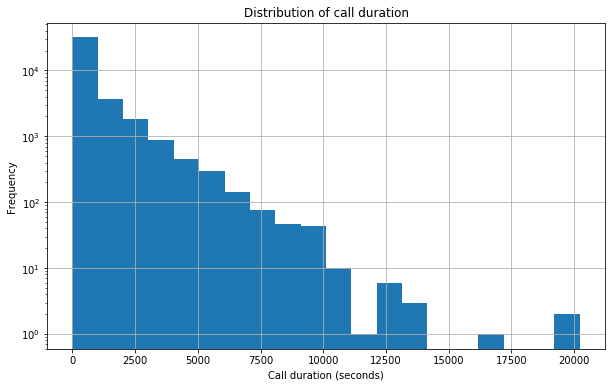

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
df['call_duration'].hist(log=True, bins=20)
plt.title('Distribution of call duration')
plt.xlabel('Call duration (seconds)')
plt.ylabel('Frequency')
plt.show()

In [43]:
np.percentile(df['call_duration'], [90, 95, 99])

array([1967. , 3048. , 5810.5])

1% of the call duration more than 5810 seconds = one hour and 36 minutes. Let's assume that call duration that lasts more than hour and a half is outlier. Delete them.

In [44]:
df = df.query('call_duration < 5400')

Let's check outliers for waiting_time.

In [45]:
df['waiting_time'].describe()

count    38673.000000
mean       151.325860
std        243.885085
min          0.000000
25%         17.000000
50%         53.000000
75%        171.000000
max       2557.000000
Name: waiting_time, dtype: float64

Maximum value of wating time is 2557 seconds = 42 minutes. It's a long wait, but things like that happen. Sometimes you call your banker and wait even more than 42 minutes for him to answer your call.

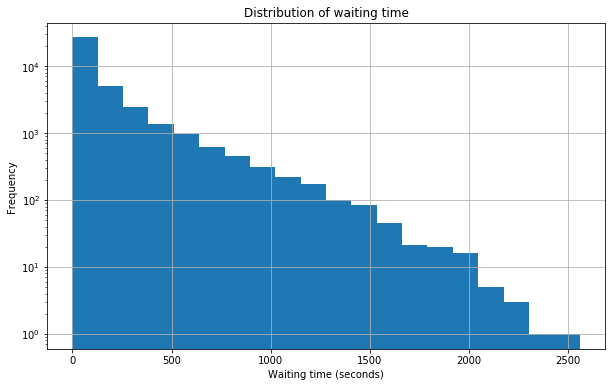

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))
df['waiting_time'].hist(log=True, bins=20)
plt.title('Distribution of waiting time')
plt.xlabel('Waiting time (seconds)')
plt.ylabel('Frequency')
plt.show()

In [47]:
np.percentile(df['waiting_time'], [90, 95, 99])

array([ 423. ,  658.4, 1211. ])

In this case I wouldn't delete nothing.

In [48]:
len(df)

38673

We lost about 29% of the data, but now our data is less messy than it was.

Summary of EDA:

Clients dataset:

* We have 732 unique users
* Three tariff plans: A, B and C. The most popular tariff plan is C (395 users), the least popular tariff - A (76 users)
* Registration dates between 01-08-2019 and 31-10-2019

df dataset:

* Only 290 of all registered users (732 users) started using their tariff plan
* We have 1092 operators
* Users can have from 1 to 50 operators
* We data on calls from 02-08-2019 till 28-11-2019. The number of calls increasing during this period. We also see peaks in some days and than downs. Probably, downs were caused by low activity at weekends
* About 70% of calls are outgoing
* About 13% of calls made between the operators
* About 34% calls were missed
* Outliers were found and deleted

### Identifying ineffective operators<a class="anchor" id="chapter4"></a>

So, let's look at missed incoming calls and defined criteria for ineffectiveness of operator.

In [49]:
df_in = df.query('direction == "in"')

Find number of missed calls per operator

In [50]:
df_in_missed_calls_2 = df_in.query('is_missed_call == True')\
                    .groupby('operator_id')['calls_count'].sum().reset_index()
df_in_missed_calls_2.columns = ['operator_id','total_missed_calls_per_operator']
df_in_missed_calls_2.head()

,operator_id,total_missed_calls_per_operator
0,882680,3
1,882684,4
2,882686,6
3,882690,2
4,884408,1


Now let's find total number of all calls per operator.

In [51]:
total_all_calls_per_operator = df.groupby('operator_id')['calls_count'].sum().reset_index()
total_all_calls_per_operator.columns = ['operator_id', 'total_all_calls']
total_all_calls_per_operator.head()

,operator_id,total_all_calls
0,879896,628
1,879898,3765
2,880020,45
3,880022,197
4,880026,2232


In [52]:
# merge two tables above
df_in_missed_calls_merge = df_in_missed_calls_2.merge(total_all_calls_per_operator, on ='operator_id')
df_in_missed_calls_merge.head()

,operator_id,total_missed_calls_per_operator,total_all_calls
0,882680,3,99
1,882684,4,1071
2,882686,6,2425
3,882690,2,961
4,884408,1,57


In [53]:
# add column with share of missed calls to total number of calls per operator
df_in_missed_calls_merge['share_of_missed_calls'] = round(df_in_missed_calls_merge['total_missed_calls_per_operator']
                                                          /df_in_missed_calls_merge['total_all_calls']*100, 2)
df_in_missed_calls_merge['share_of_missed_calls'].describe()

count    200.000000
mean       2.437350
std        5.494752
min        0.030000
25%        0.230000
50%        0.615000
75%        2.710000
max       50.000000
Name: share_of_missed_calls, dtype: float64

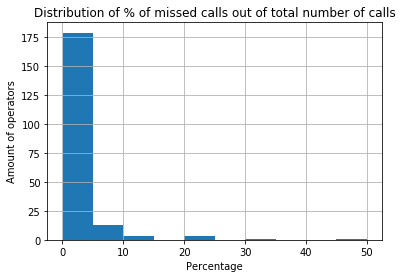

In [54]:
df_in_missed_calls_merge['share_of_missed_calls'].hist()
plt.title('Distribution of % of missed calls out of total number of calls')
plt.xlabel('Percentage')
plt.ylabel('Amount of operators')
plt.show()

In [55]:
np.percentile(df_in_missed_calls_merge['share_of_missed_calls'], [90, 95])

array([5.56 , 9.684])

We will use 90th percentile to define a threshold for a share of missed calls. Above this threshold the share of missed calls we'll be considered as large share of missed calls.

#### Operator considered ineffective if he has a share of missed incoming calls more than 5%. This is our first criteria for ineffectiveness. 


Let's write a function that will mark the operators with share of missed calls more than 5% as "large share of missed calls". Than look how many such operators do we have.

In [56]:
def missed_call(share_of_missed_calls):
    if share_of_missed_calls > 5:
        return 'large share of missed calls'
    else:
        return 'ok'

In [57]:
df_in_missed_calls_merge.head()

,operator_id,total_missed_calls_per_operator,total_all_calls,share_of_missed_calls
0,882680,3,99,3.03
1,882684,4,1071,0.37
2,882686,6,2425,0.25
3,882690,2,961,0.21
4,884408,1,57,1.75


In [58]:
df_in_missed_calls_merge['criteria_1'] = df_in_missed_calls_merge['share_of_missed_calls'].apply(missed_call)

In [59]:
# only ineffective operators
df_in_missed_calls_merge_ineffect = df_in_missed_calls_merge.query('criteria_1 == "large share of missed calls"')
df_in_missed_calls_merge_ineffect['operator_id'].nunique()

21

We have 21 operators that have a ahare of missed calls more than 5%.

Let's defined the second criteria - a long waiting time for incoming calls. 

In [60]:
df_in_waiting_time = df_in.groupby('operator_id')['avg_waiting_time_per_call'].mean().reset_index()
df_in_waiting_time.head()

,operator_id,avg_waiting_time_per_call
0,879896,13.396199
1,879898,14.206548
2,880020,7.714286
3,880022,14.000000
4,880026,5.935185


In [61]:
df_in_waiting_time['avg_waiting_time_per_call'].describe()

count    753.000000
mean      17.773307
std       12.269000
min        0.678944
25%        9.466667
50%       14.628354
75%       22.250000
max      115.500000
Name: avg_waiting_time_per_call, dtype: float64

In [62]:
np.percentile(df_in_waiting_time['avg_waiting_time_per_call'], [90, 95, 99])

array([33.96388778, 41.94      , 57.22      ])

In case of waiting time, we would use 90th percentile as a criteria for a long waiting time. It is very annoying to wait till the operator will answer your call.

#### So, our second criteria: more than 30 seconds wait will consider  as a long waiting time 

Write a function that will mark the operators with waiting time more than 30 seconds as "long waiting time". Than look how many such operators do we have.

In [63]:
def waiting_time(avg_waiting_time_per_call):
    if avg_waiting_time_per_call > 30:
        return 'long waiting time'
    else:
        return 'ok'

In [64]:
df_in_waiting_time['criteria_2'] = df_in_waiting_time['avg_waiting_time_per_call']\
                                    .apply(waiting_time)

df_in_waiting_time.head()

,operator_id,avg_waiting_time_per_call,criteria_2
0,879896,13.396199,ok
1,879898,14.206548,ok
2,880020,7.714286,ok
3,880022,14.000000,ok
4,880026,5.935185,ok


In [65]:
# only ineffective operators
df_in_waiting_time_ineffect = df_in_waiting_time.query('criteria_2 == "long waiting time"')
df_in_waiting_time_ineffect['operator_id'].nunique()

97

So, we have 97 operators with more than 30 seconds waiting time.

Now, let's define the third criteria. 

In [66]:
df_out = df.query('direction == "out"')

In [67]:
# total of outgoing calls per operator 
df_out_calls = df_out.groupby('operator_id')['calls_count'].sum().reset_index()
df_out_calls.head()

,operator_id,calls_count
0,879896,570
1,879898,3662
2,880020,38
3,880022,189
4,880026,2208


In [68]:
# merge two tables total_all_calls_per_operator and df_out_calls
df_out_calls_merge = df_out_calls.merge(total_all_calls_per_operator, on = 'operator_id')
df_out_calls_merge.head()

,operator_id,calls_count,total_all_calls
0,879896,570,628
1,879898,3662,3765
2,880020,38,45
3,880022,189,197
4,880026,2208,2232


In [69]:
# add column with share of outgoing calls out of total calls per operator 
df_out_calls_merge['share_of_out_to_total_%'] = round(df_out_calls_merge['calls_count']/
                                                              df_out_calls_merge['total_all_calls']*100, 2)
df_out_calls_merge.head()

,operator_id,calls_count,total_all_calls,share_of_out_to_total_%
0,879896,570,628,90.76
1,879898,3662,3765,97.26
2,880020,38,45,84.44
3,880022,189,197,95.94
4,880026,2208,2232,98.92


In [70]:
df_out_calls_merge['share_of_out_to_total_%'].describe()

count    882.000000
mean      79.475692
std       26.985185
min        0.150000
25%       65.987500
50%       93.405000
75%      100.000000
max      100.000000
Name: share_of_out_to_total_%, dtype: float64

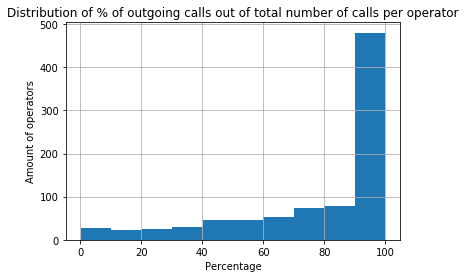

In [71]:
df_out_calls_merge['share_of_out_to_total_%'].hist()
plt.title('Distribution of % of outgoing calls out of total number of calls per operator')
plt.xlabel('Percentage')
plt.ylabel('Amount of operators')
plt.show()

In [72]:
np.percentile(df_out_calls_merge['share_of_out_to_total_%'], [10, 20, 25, 30])

array([34.738 , 56.748 , 65.9875, 72.57  ])

Let's take 25th percentile as a threshold.

#### Third criteria: operators that have a share of outgoing calls less than 65% are considered ineffective.

Write a function that will mark the operators with share of outgoing calls less than 65% as "small share of outgoing calls". Than look how many such operators do we have.

In [73]:
def outgoing_calls(share_of_out_calls):
    if share_of_out_calls < 65:
        return 'small share of outgoing calls'
    else:
        return 'ok'

In [74]:
df_out_calls_merge['criteria_3'] = df_out_calls_merge['share_of_out_to_total_%'].apply(outgoing_calls)

df_out_calls_merge.head()

,operator_id,calls_count,total_all_calls,share_of_out_to_total_%,criteria_3
0,879896,570,628,90.76,ok
1,879898,3662,3765,97.26,ok
2,880020,38,45,84.44,ok
3,880022,189,197,95.94,ok
4,880026,2208,2232,98.92,ok


In [75]:
# only ineffective operators
df_out_calls_merge_ineffect = df_out_calls_merge.query('criteria_3 == "small share of outgoing calls"')
df_out_calls_merge_ineffect['operator_id'].nunique()

217

We have 217 operators that have small share of outgoing calls.

In [76]:
ineffective = df_in_missed_calls_merge_ineffect.merge(df_in_waiting_time_ineffect, on ='operator_id', how = 'outer')\
                            .merge(df_out_calls_merge_ineffect, on = 'operator_id', how = 'outer')
ineffective.head(5)

,operator_id,total_missed_calls_per_operator,total_all_calls_x,share_of_missed_calls,criteria_1,avg_waiting_time_per_call,criteria_2,calls_count,total_all_calls_y,share_of_out_to_total_%,criteria_3
0,888406,1.0,15.0,6.67,large share of missed calls,NaN,NaN,6.0,15.0,40.0,small share of outgoing calls
1,894120,1.0,18.0,5.56,large share of missed calls,NaN,NaN,NaN,NaN,NaN,NaN
2,894614,1.0,8.0,12.50,large share of missed calls,NaN,NaN,NaN,NaN,NaN,NaN
3,896538,1.0,14.0,7.14,large share of missed calls,48.090909,long waiting time,NaN,NaN,NaN,NaN
4,899268,2.0,31.0,6.45,large share of missed calls,NaN,NaN,NaN,NaN,NaN,NaN


Write a function that summarize all three criterias:
* If operator has large share of missed calls and long waiting time and small share of outgoing calls his is "bad at all".
* If operator is bad in two of three criterias, we'll write those two criterias.
* If operator is bad only in one criteria, we'll write this criteria

In [77]:
def total_criteria(row):
    if (row['criteria_1'] == "large share of missed calls") & (row['criteria_2'] == "long waiting time") & (row['criteria_3'] == "small share of outgoing calls"):
        return "bad at all"
    if (row['criteria_2'] == "long waiting time") & (row['criteria_3'] == "small share of outgoing calls"):
        return "long wait and small share of outgoing calls"
    if (row['criteria_1'] == "large share of missed calls") & (row['criteria_3'] == "small share of outgoing calls"):
        return "large share of missed calls and small share of outgoing calls"
    if (row['criteria_1'] == "large share of missed calls") & (row['criteria_2'] == "long waiting time"):
        return "large share of missed calls and long wait"
    if row['criteria_1'] == "large share of missed calls":
        return "large share of missed calls"
    if row['criteria_2'] == "long waiting time":
        return "long waiting time"
    if row['criteria_3'] == "small share of outgoing calls":
        return "small share of outgoing calls"
    else:
        return "other"

In [78]:
ineffective['total_criteria'] = ineffective.apply(total_criteria, axis = 1)
ineffective.head()

,operator_id,total_missed_calls_per_operator,total_all_calls_x,share_of_missed_calls,criteria_1,avg_waiting_time_per_call,criteria_2,calls_count,total_all_calls_y,share_of_out_to_total_%,criteria_3,total_criteria
0,888406,1.0,15.0,6.67,large share of missed calls,NaN,NaN,6.0,15.0,40.0,small share of outgoing calls,large share of missed calls and small share of...
1,894120,1.0,18.0,5.56,large share of missed calls,NaN,NaN,NaN,NaN,NaN,NaN,large share of missed calls
2,894614,1.0,8.0,12.50,large share of missed calls,NaN,NaN,NaN,NaN,NaN,NaN,large share of missed calls
3,896538,1.0,14.0,7.14,large share of missed calls,48.090909,long waiting time,NaN,NaN,NaN,NaN,large share of missed calls and long wait
4,899268,2.0,31.0,6.45,large share of missed calls,NaN,NaN,NaN,NaN,NaN,NaN,large share of missed calls


In [79]:
ineffect = ineffective['total_criteria'].value_counts().reset_index()
ineffect.columns =['criteria', 'num_of_operators']
ineffect

,criteria,num_of_operators
0,small share of outgoing calls,180
1,long waiting time,65
2,long wait and small share of outgoing calls,29
3,large share of missed calls,11
4,large share of missed calls and small share of...,7
5,large share of missed calls and long wait,2
6,bad at all,1


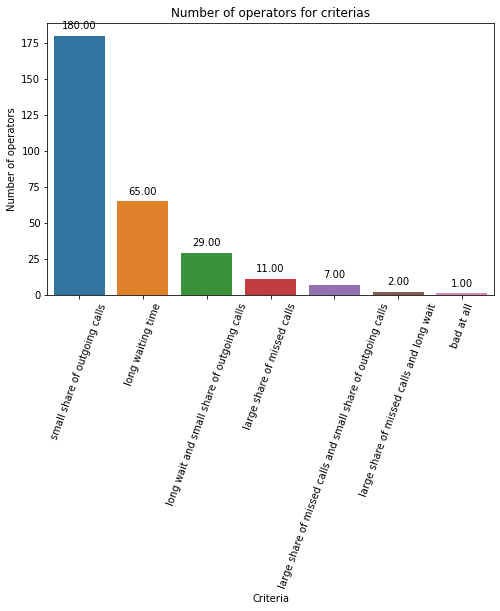

In [80]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data = ineffect, x='criteria', y='num_of_operators')

plt.title('Number of operators for criterias')
plt.xlabel('Criteria')
plt.ylabel('Number of operators')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                xy=(p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
    
for item in ax.get_xticklabels():
    item.set_rotation(70)

plt.show()

We used 90th percentile to define a threshold for a share of missed calls. So, our first criteria for ineffectiveness is: 

#### Operator considered ineffective if he has a share of missed incoming calls more than 5%. 

We used 90th percentile to determine the threshold for a long waiting time. So, our second criteria is: 

#### Waiting time more than 30 seconds consider as a long waiting time.

We used 25th percentile as a threshold for small share of outgoing calls. So, the third criteria is: 

#### Operators that have a share of outgoing calls less than 65% are considered ineffective.


Operators that have all three criterias simultaneously:

* We have only 1 operator that is "bad" at all three criterias simultaneously.

Operators that have two criterias simultaneously:

* 29 operators have long wait and small share of outgoing calls
* 7 operators large share of missed calls and small share of outgoing calls
* 2 operators large share of missed calls and long wait

Operators that have only one criteria:

* 180 operators have small share of outgoing calls
* 65 have long waiting time
* 11 operator has large share of missed calls

So, we identified 295 ineffective operators. About 61% of them have small share of outgoing calls.  About 22% of all ineffective operators have long waiting time. It's really annoying to wait until your operator answers your call and may cause a loss of clients. About 9% have both criterias above: long wait and small share of outgoing calls. 3% have large share of missed calls.  


### Testing hypothesis<a class="anchor" id="chapter5"></a>

Let's check if there is statistically significant difference in average waiting time between effective and ineffective operators. 

* Ineffective operators

In [81]:
df_in_waiting_time_ineffect['avg_waiting_time_per_call'].describe()

count     97.000000
mean      42.430151
std       12.773510
min       30.017857
25%       34.500000
50%       39.139216
75%       46.187500
max      115.500000
Name: avg_waiting_time_per_call, dtype: float64

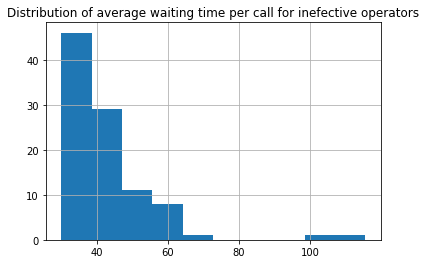

In [82]:
df_in_waiting_time_ineffect['avg_waiting_time_per_call'].hist()
plt.title("Distribution of average waiting time per call for inefective operators")
plt.show()

* Effective operators

Effective operators are those who do not have any of the three criteria (they have "ok" for all three criteria).

In [83]:
# operator_id of ineffective operators
ineffective_id = ineffective['operator_id'].to_numpy()

# data for effective operators
effective = df_in[~df_in['operator_id'].isin(ineffective_id)]

In [84]:
df_in_waiting_time_effect = effective.groupby('operator_id')['avg_waiting_time_per_call'].mean().reset_index()
df_in_waiting_time_effect['avg_waiting_time_per_call'].describe()

count    458.000000
mean      14.312069
std        6.531788
min        0.833333
25%        9.175000
50%       13.717437
75%       18.459259
max       30.000000
Name: avg_waiting_time_per_call, dtype: float64

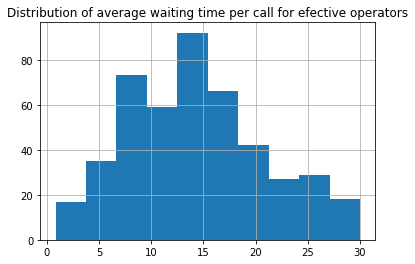

In [85]:
df_in_waiting_time_effect['avg_waiting_time_per_call'].hist()
plt.title("Distribution of average waiting time per call for efective operators")
plt.show()

Let's define hipothesis

Null Hypothesis H0: There is no statistically significant difference in average waiting time between effective and ineffective operators. 

Alternative Hypothesis H1: There is a statistically significant difference in average waiting time between effective and ineffective operators. 

Let's set alpha value to 0.05.

#### The data isn't distributed normally, so we'll use Mann-Whitney test

In [86]:
alpha = 0.05
p_value = st.mannwhitneyu(df_in_waiting_time_effect['avg_waiting_time_per_call'], df_in_waiting_time_ineffect['avg_waiting_time_per_call'])[1]

print('P_value is: {} \n'.format(p_value))
if p_value < alpha:
    print('Reject Null hypothesis: There is a statistically significant difference in average waiting time between effective and ineffective operators.')
else:
    print('Failed to reject Null hypothesis: There is no statistically significant difference in average waiting time between effective and ineffective operators.')

P_value is: 2.279390812196953e-54 

Reject Null hypothesis: There is a statistically significant difference in average waiting time between effective and ineffective operators.


P_value is much smaller than alpha. So, we reject Null hypothesis and say that there is a statistically significant difference in average waiting time between effective and ineffective operators. 

### Conclusions<a class="anchor" id="chapter6"></a>

Clients dataset:

* We have 732 unique users
* Three tariff plans: A, B and C. The most popular tariff plan is C (395 users), the least popular tariff - A (76 users)
* Registration dates between 01-08-2019 and 31-10-2019

df dataset:

* Only 290 of all registered users (732 users) started using their tariff plan
* We have 1092 operators
* Users can have from 1 to 50 operators
* We data on calls from 02-08-2019 till 28-11-2019. The number of calls increasing during this period. We also see peaks in some days and than downs. Probably, downs were caused by low activity at weekends
* About 70% of calls are outgoing
* About 13% of calls made between the operators
* About 34% calls were missed

Identifying ineffective operators: 

We used 90th percentile to define a threshold for a share of missed calls. So, our first criteria for ineffectiveness is: 

#### Operator considered ineffective if he has a share of missed incoming calls more than 5%. 

We used 90th percentile to determine the threshold for a long waiting time. So, our second criteria is: 

#### Waiting time more than 30 seconds consider as a long waiting time.

We used 25th percentile as a threshold for small share of outgoing calls. So, the third criteria is: 

#### Operators that have a share of outgoing calls less than 65% are considered ineffective.


Operators that have all three criterias simultaneously:

* We have only 1 operator that is "bad" at all three criterias simultaneously.

Operators that have two criterias simultaneously:

* 29 operators have long wait and small share of outgoing calls
* 7 operators large share of missed calls and small share of outgoing calls
* 2 operators large share of missed calls and long wait

Operators that have only one criteria:

* 180 operators have small share of outgoing calls
* 65 have long waiting time
* 11 operator has large share of missed calls

So, we identified 295 ineffective operators. About 61% of them have small share of outgoing calls.  About 22% of all ineffective operators have long waiting time. It's really annoying to wait until your operator answers your call and may cause a loss of clients. About 9% have both criterias above: long wait and small share of outgoing calls. 3% have large share of missed calls.  

Testing hypothesis:

We checked if there is statistically significant difference in average waiting time between effective and ineffective operators.

We got p_value is much smaller than alpha. So, we rejected Null hypothesis and said that there was a statistically significant difference in average waiting time between effective and ineffective operators.

#### We suggest stopping using all inefficient operators.
